In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
#from pls_m4 import *
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [2]:
df_orig = pd.read_csv('final_data_files/all_possible_photometry.csv')

In [3]:
for label in ['j', 'h', 'k', '3', '4']:
    print label, len(df_orig['mag_{}'.format(label)][np.isfinite(df_orig['mag_{}'.format(label)])])

j 170
h 168
k 171
3 73
4 49


In [4]:
# bad_ids = [103, 107]#, 40, 169]#, 169] #120, , 357
# df_bad = df_orig[df_orig.id.isin(bad_ids)]
# df_bad_ab = df_bad[df_bad.type == 0]
# df_bad_c = df_bad[df_bad.type == 1]

df = df_orig#[~df_orig.id.isin(bad_ids)]

In [5]:
# things for plotting loop
#funcs = [j_ab, j_c, h_ab, h_c, k_ab, k_c, t_ab, t_c, f_ab, f_c]
band_labels = ['j', 'h', 'k', '3', '4']
band_names = ['J', 'H', 'K_s', '[3.6]', '[4.5]']
cmap = plt.cm.get_cmap('gist_rainbow')
plot_colors = list(reversed([cmap(i) for i in np.linspace(0,0.91,len(band_labels))]))
mag_offset = [8,6,4,2,0]
wavelength = [1.220, 1.630, 2.190, 3.550, 4.493]

In [6]:
# select only the rows with photometry for all bands
df1 = df[(np.isfinite(df.mag_j)) & (np.isfinite(df.mag_h)) & (np.isfinite(df.mag_k)) &
        ((np.isfinite(df.mag_3)) | (np.isfinite(df.mag_4)))]

In [7]:
p0_ab = np.mean(np.log10(df.per[df.type == 0]))
print p0_ab
p0_c = np.mean(np.log10(df.per[df.type == 1]))
print p0_c

-0.190462190692
-0.450299111208


In [8]:
def fitfunc_ab(x,slope,zpt):
    return zpt + slope*(x-p0_ab)
def fitfunc_c(x,slope,zpt):
    return zpt + slope*(x-p0_c)

J ab -2.68440197645 0.445768700536 13.3696474218 0.03158658788
J c -2.25636426927 0.30882123901 13.6098500924 0.0191158256001
0.0337622501013 0.0660747411414 0.0144870073575 0.0294323831808
H ab -3.20781942438 0.586908266302 13.0998503653 0.0415875514703
H c -2.8632639814 0.656435708732 13.3899401046 0.0406329218581
0.0245266557434 0.0521547368262 0.020589407896 0.0691833241952
K_s ab -3.03987620584 0.54687502892 13.0169964973 0.0387508499533
K_s c -2.6859378486 0.48532423792 13.3352956301 0.0300412392518
0.02272246353 0.0704818826625 0.0217687394571 0.068726123743
[3.6] ab -1.1351212522 0.740859614646 13.0975780571 0.0542082221836
[3.6] c -3.24955672883 0.946280204386 13.443482034 0.0622993601738
-0.0788198303108 -0.000486390904948 2.43415243517e-09 0.013013193691
[4.5] ab -3.44059618126 0.868665553698 13.1115096025 0.0667005825419
[4.5] c -3.05040070656 1.54904622569 13.5125927135 0.0879807260094
-3.416070845e-16 0.00445883628584 -0.0413938250704 -0.0351747505734


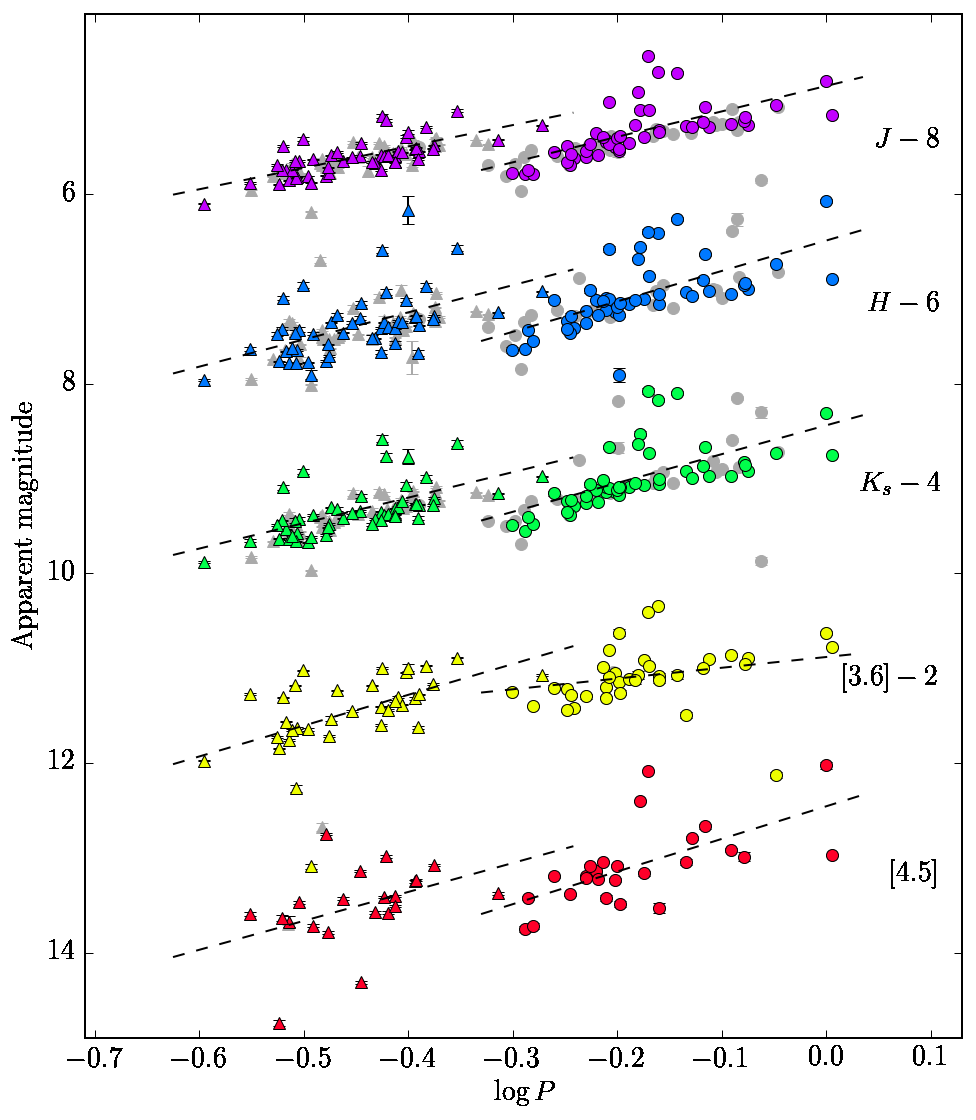

In [9]:
fig = plt.figure(figsize=(7,8))
ax = fig.add_subplot(1,1,1)
ax.set_ylim(14.9, 4.1)
ax.set_xlim(-0.71, 0.13)

# separate full and cut sample dataframes into abs and cs
df_ab = df[df.type == 0]
df_c = df[df.type == 1]

df1_ab = df1[df1.type == 0]
df1_c = df1[df1.type == 1]

slope_prior = -2.
zpt_prior = 14
#feh = -1.56749344383

per_ab_0 = np.log10(df1_ab.per)
per_c_0 = np.log10(df1_c.per)
xspace_ab = np.linspace(np.min(per_ab_0) - 0.03, np.max(per_ab_0) + 0.03, 100)
xspace_c = np.linspace(np.min(per_c_0) - 0.03, np.max(per_c_0) + 0.03, 100)

params_df = {}
params_df['wavelength'] = wavelength
params_df['slope_ab'] = []
params_df['slope_c'] = []
params_df['slope_err_ab'] = []
params_df['slope_err_c'] = []
params_df['zpt_ab'] = []
params_df['zpt_c'] = []
params_df['zpt_err_ab'] = []
params_df['zpt_err_c'] = []

for i in range(len(band_labels)):
    mag_ab = df1_ab['mag_' + band_labels[i]][np.isfinite(df1_ab['mag_' + band_labels[i]])]
    merr_ab = df1_ab['merr_' + band_labels[i]][np.isfinite(df1_ab['mag_' + band_labels[i]])]
    mag_c = df1_c['mag_' + band_labels[i]][np.isfinite(df1_c['mag_' + band_labels[i]])]
    merr_c = df1_c['merr_' + band_labels[i]][np.isfinite(df1_c['mag_' + band_labels[i]])]
    per_ab = per_ab_0[np.isfinite(df1_ab['mag_' + band_labels[i]])]
    per_c = per_c_0[np.isfinite(df1_c['mag_' + band_labels[i]])]
    
    # do the fitting
    popt_ab, pcov_ab = curve_fit(fitfunc_ab, per_ab, mag_ab, p0 = [slope_prior, zpt_prior])
    popt_c, pcov_c = curve_fit(fitfunc_c, per_c, mag_c, p0 = [slope_prior, zpt_prior])
    slope_ab, slope_err_ab = popt_ab[0], np.sqrt(np.diag(pcov_ab))[0]
    zpt_ab, zpt_err_ab = popt_ab[1], np.sqrt(np.diag(pcov_ab))[1]
    slope_c, slope_err_c = popt_c[0], np.sqrt(np.diag(pcov_c))[0]
    zpt_c, zpt_err_c = popt_c[1], np.sqrt(np.diag(pcov_c))[1]
    
    params_df['slope_ab'].append(slope_ab)
    params_df['slope_err_ab'].append(slope_err_ab)
    params_df['zpt_ab'].append(zpt_ab)
    params_df['zpt_err_ab'].append(zpt_err_ab)
    params_df['slope_c'].append(slope_c)
    params_df['slope_err_c'].append(slope_err_c)
    params_df['zpt_c'].append(zpt_c)
    params_df['zpt_err_c'].append(zpt_err_c)
            
    # fit lines for plotting + get residuals
    linfit_ab = fitfunc_ab(xspace_ab, slope_ab, zpt_ab)
    linfit_c = fitfunc_c(xspace_c, slope_c, zpt_c)
    
    # get all residuals and update dataframe with them
    df_ab_filter = df_orig[np.isfinite(df_orig['mag_' + band_labels[i]]) & (df_orig.type == 0)]
    df_c_filter = df_orig[np.isfinite(df_orig['mag_' + band_labels[i]]) & (df_orig.type == 1)]
    resid_ab = df_ab_filter['mag_' + band_labels[i]] - fitfunc_ab(np.log10(df_ab_filter.per), slope_ab, zpt_ab)
    resid_c = df_c_filter['mag_' + band_labels[i]] - fitfunc_c(np.log10(df_c_filter.per), slope_c, zpt_c)
    df_orig['resid_' + band_labels[i]].update(resid_ab)
    df_orig['resid_' + band_labels[i]].update(resid_c)
    
    print band_names[i], 'ab', slope_ab, slope_err_ab, zpt_ab, zpt_err_ab
    print band_names[i], 'c', slope_c, slope_err_c, zpt_c, zpt_err_c
    print np.mean(resid_ab), np.median(resid_ab), np.mean(resid_c), np.median(resid_c)
    
    # plot full sample in grey
    plt.errorbar(np.log10(df_ab.per), df_ab['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_ab['merr_' + band_labels[i]].values, fmt='o', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)
    plt.errorbar(np.log10(df_c.per), df_c['mag_' + band_labels[i]] - mag_offset[i],
                 yerr=df_c['merr_' + band_labels[i]].values, fmt='^', color='#AAAAAA',
                 mec='#AAAAAA', zorder=-1)

    #err_wtf = df_bad_ab['merr_' + band_labels[i]].values
                     
#     plt.errorbar(np.log10(df_bad_ab.per), df_bad_ab['mag_' + band_labels[i]] - mag_offset[i],
#                  yerr=df_bad_ab['merr_' + band_labels[i]].values, fmt='o', color='k',
#                  mfc='w', zorder=10)
#     plt.errorbar(np.log10(df_bad_c.per), df_bad_c['mag_' + band_labels[i]] - mag_offset[i],
#                  yerr=df_bad_c['merr_' + band_labels[i]].values, fmt='^', color='k',
#                  mfc='w', zorder=10)
    

    # plot cut sample in color
    plt.errorbar(per_ab.values, mag_ab.values - mag_offset[i], yerr=merr_ab.values, fmt='o',
                 mfc=plot_colors[i], color='k')
    plt.errorbar(per_c.values, mag_c.values - mag_offset[i], yerr=merr_c.values,
                 fmt='^', mfc=plot_colors[i], color='k')
        
    ppl.plot(xspace_ab, linfit_ab - mag_offset[i], 'k--', lw=1)
    ppl.plot(xspace_c, linfit_c - mag_offset[i], 'k--', lw=1)
    
    # add labels
    if mag_offset[i] == 0:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.1),
                 '${}$'.format(band_names[i]), ha='right')
    else:
        plt.text(ax.get_xlim()[1] - 0.02, np.median(mag_ab - mag_offset[i] + 0.1),
                 '${} - {}$'.format(band_names[i], mag_offset[i]), ha='right')

        
# df_81 = df_orig[df_orig.id==81]
# herp = df_81.filter(regex='mag').values - mag_offset
# derp = np.log10(df_81.per.values.repeat(5))
# #print herp[0], derp
# plt.errorbar(derp, herp[0], fmt='o', color='k')

ax.set_ylabel('Apparent magnitude')
ax.set_xlabel(r'$\log P$')
fig.tight_layout()
#fig.savefig('final_plots/omegacen_pl_fits.pdf')

In [12]:
params_df = pd.DataFrame.from_dict(params_df)
params_df = params_df[['wavelength','slope_ab','slope_err_ab','zpt_ab','zpt_err_ab',
                           'slope_c','slope_err_c','zpt_c','zpt_err_c']]
params_df.to_csv('final_data_files/omegacen_fit_params.csv', index=False)

In [13]:
df_orig.to_csv('final_data_files/all_possible_photometry_withresid.csv',index=False)